<p style="background-color:#CC9911;text-align:center;vertical-align: middle;padding:30px;font-family:courier;font-size:30px;color:black">
    Libraries
</p>

In [1]:
from torch import nn
import numpy as np
import datetime
import torch
import cv2
import gym
import os
from time import sleep
import pathlib
import matplotlib.pyplot as plt
import random
from collections import deque

<p style="background-color:#CC9911;text-align:center;vertical-align: middle;padding:30px;font-family:courier;font-size:30px;color:black">
    Main
</p>

In [1]:
# https://github.com/ZachisGit/LearningFromHumanPreferences

from torch import nn
import numpy as np
import datetime
import torch
import cv2
import gym
import os
from time import sleep
import pathlib
import matplotlib.pyplot as plt


class HumanPref(nn.Module):
    def __init__(self, obs_size, neuron_size=64):
        super(HumanPref, self).__init__()

        self.obs_size = obs_size
        self.neuron_size = neuron_size

        self.dense1 = nn.Linear(self.obs_size, self.neuron_size)
        self.dense2 = nn.Linear(self.neuron_size, 1)

        self.batch_norm = nn.BatchNorm1d(1)

    def forward(self, x1, x2=None):

        model1_couche1 = self.dense1(x1)
        model1_couche2 = torch.nn.functional.relu(model1_couche1)
        model1_couche3 = self.dense2(model1_couche2)
        model1_couche4 = self.batch_norm(model1_couche3)
        if x2 is None:
            return model1_couche4
        else:
            model2_couche1 = self.dense1(x2)
            model2_couche2 = torch.nn.functional.relu(model2_couche1)
            model2_couche3 = self.dense2(model2_couche2)
            model2_couche4 = self.batch_norm(model2_couche3)
            # output = nn.functional.softmax(torch.stack([model1_couche4, model2_couche4]), dim=0)
            p1_sum = torch.exp(torch.sum(model1_couche1)/len(x1))
            p2_sum = torch.exp(torch.sum(model2_couche4)/len(x2))
            p1 = p1_sum/torch.add(p1_sum, p2_sum)
            p2 = p2_sum / torch.add(p1_sum, p2_sum)
            return torch.stack([p1, p2])


class HumanPreference(object):
    def __init__(self, obs_size, action_size):
        self.trijectories = []
        self.preferences = []
        self.layer_count = 3
        self.neuron_size_init = 64
        self.batch_size_init = 10
        self.learning_rate = 0.00025
        self.obs_size = obs_size
        self.action_size = action_size
        self.neuron_size = obs_size ** 3
        self.loss_l = []

        self.create_model()

    def create_model(self):
        self.model = HumanPref(self.obs_size, self.neuron_size)
        self.criterion = nn.functional.binary_cross_entropy
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def train(self):
        self.model.train()
        if len(self.preferences) < 5:
            return

        batch_size = min(len(self.preferences), self.batch_size_init)
        r = np.asarray(range(len(self.preferences)))
        np.random.shuffle(r)

        min_loss = 1e+10
        max_loss = -1e+10
        lo = 0.0
        for i in r[:batch_size]:
            x0, x1, preference = self.preferences[i]

            pref_dist = np.zeros([2], dtype=np.float32)
            if preference < 2:
                pref_dist[preference] = 1.0
            else:
                pref_dist[:] = 0.5

            x0 = torch.from_numpy(np.asarray(x0)).float()
            x1 = torch.from_numpy(np.asarray(x1)).float()
            y = torch.from_numpy(pref_dist)
            y_hat = self.model(x0, x1)

            loss = self.criterion(y_hat, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if loss.item() > max_loss:
                max_loss = loss.item()
            elif loss.item() < min_loss:
                min_loss = loss.item()

            lo = loss.item()
        print("[ Loss: actual loss =", lo, " max =", max_loss, " min =", min_loss, "]")

        self.loss_l.append(lo)

    def predict(self, obs):
        self.model.eval()
        obs = torch.tensor([obs]).float()
        pred = self.model(obs)
        return pred.detach().numpy()

    def add_preference(self, o0, o1, preference):
        self.preferences.append([o0, o1, preference])

    def add_trijactory(self, trijectory_env_name,  trijectory):
        self.trijectories.append([trijectory_env_name, trijectory])

    def ask_human(self):

        if len(self.trijectories) < 2:
            return

        r = np.asarray(range(len(self.trijectories)))
        np.random.shuffle(r)
        t = [self.trijectories[r[0]], self.trijectories[r[1]]]

        envs = []
        for i in range(len(t)):
            env_name, trijectory = t[i]
            env = gym.make(env_name)
            env.reset()
            env.render()
            envs.append(env)

        cv2.imshow("", np.zeros([1, 1], dtype=np.uint8))

        print("Preference (1,2|3):")
        env_idxs = np.zeros([2], dtype=np.int32)
        preference = -1
        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('1'):
                preference = 0
            elif key == ord('2'):
                preference = 1
            elif key == ord('3') or key == ord('0'):
                preference = 2

            if preference != -1:
                break

            for i in range(len(t)):
                envs[i].render()

                env_name, trijectory = t[i]
                obs, future_obs, action, done = trijectory[env_idxs[i]]
                envs[i].step(action)
                env_idxs[i] += 1
                if done or env_idxs[i] >= len(trijectory):
                    envs[i].reset()
                    env_idxs[i] = 0
            sleep(0.02)

        if preference != -1:
            os = []
            for i in range(len(t)):
                env_name, trijectory = t[i]
                o = []

                for j in range(len(trijectory)):
                    o.append(trijectory[j][1])

                os.append(o)

            self.add_preference(os[0], os[1], preference)

        cv2.destroyAllWindows()
        for i in range(len(envs)):
            envs[i].close()

        if preference == 0:
            print(1)
        elif preference == 1:
            print(2)
        elif preference != -1:
            print("neutral")
        else:
            print("no oppinion")


    def plot(self):
        x = np.arange(0, len(self.loss_l))
        y = np.asarray(self.loss_l)
        fig, ax = plt.subplots()
        ax.plot(y)
        ax.set_xlabel('epochs')
        ax.set_ylabel('loss')
        ax.set_title('Loss per epochs')

        # datetime_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        # path = os.path.join(pathlib.Path().absolute(), 'plots', 'hp_model', 'hp_model' + datetime_str + ".png")
        # plt.savefig(path)

Run: 1, exploration: 1.0, score: 18
Run: 2, exploration: 0.918316468354365, score: 19
Run: 3, exploration: 0.8433051360508336, score: 18
Run: 4, exploration: 0.7552531090661897, score: 23
Run: 5, exploration: 0.6369088258938781, score: 35
Preference (1,2|3):
neutral
Run: 6, exploration: 0.5997278763867329, score: 13
Run: 7, exploration: 0.5647174463480732, score: 13
Run: 8, exploration: 0.5344229416520513, score: 12
Run: 9, exploration: 0.4858739637363176, score: 20
Run: 10, exploration: 0.43732904629000013, score: 22
Preference (1,2|3):
neutral
Run: 11, exploration: 0.4016064652978155, score: 18
Run: 12, exploration: 0.3596735257153405, score: 23
Run: 13, exploration: 0.3063705780533402, score: 33
Run: 14, exploration: 0.27853872940185365, score: 20
Run: 15, exploration: 0.24696734223472733, score: 25
Preference (1,2|3):
neutral
Run: 16, exploration: 0.19415447453059972, score: 49
Run: 17, exploration: 0.15035730121053842, score: 52
Run: 18, exploration: 0.12242520289863423, score: 42

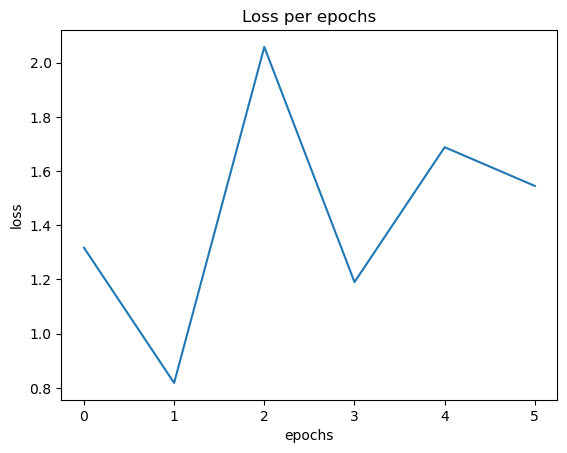

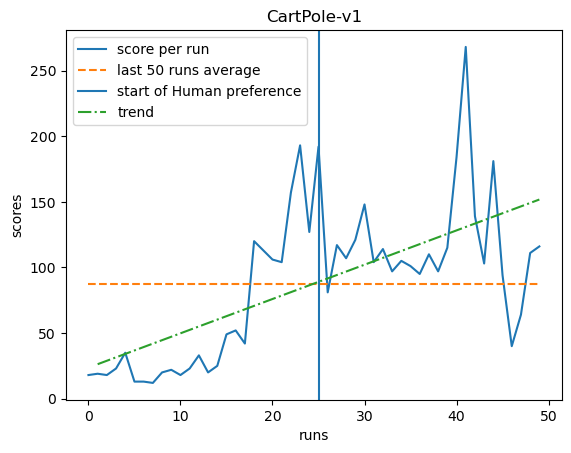

In [8]:
import random
import gym
import numpy as np
from collections import deque
import os
import matplotlib.pyplot as plt
import datetime
import pathlib
import torch
from torch import nn

mode = "Human"  # "Human" pour avoir les préférences humaines sur les rewards, "self" pour avoir les rewards par défaut
ENV_NAME = "CartPole-v1"

GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 1000000
BATCH_SIZE = 20

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995

CONSECUTIVE_RUNS_TO_SOLVE = 100


class NN(nn.Module):
    def __init__(self, obs_size, action_size):
        super(NN, self).__init__()
        self.dense1 = nn.Linear(obs_size, 24)
        self.dense2 = nn.Linear(24, 24)
        self.dense3 = nn.Linear(24, 24)
        self.dense4 = nn.Linear(24, action_size)

    def forward(self, x):
        l1 = self.dense1(x)
        l2 = nn.functional.relu(l1)
        l3 = self.dense2(l2)
        l4 = nn.functional.relu(l3)
        l5 = self.dense3(l4)
        l6 = nn.functional.relu(l5)
        output = self.dense4(l6)
        return output


class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.scores = deque(maxlen=CONSECUTIVE_RUNS_TO_SOLVE)

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.rl_model = NN(observation_space, action_space)

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.rl_model.parameters(), lr=LEARNING_RATE)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        q_values = self.rl_model(torch.tensor(state).float()).detach().numpy()
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_pred = self.rl_model(torch.tensor(state_next).float()).detach().numpy()
                q_update = (reward + GAMMA * np.amax(q_pred))
            q_values = self.rl_model(torch.tensor(state).float()).detach().numpy()
            q_values[0][action] = q_update

            x = torch.from_numpy(state).float()
            y = torch.from_numpy(q_values).float()

            y_hat = self.rl_model(x)
            loss = self.criterion(y_hat, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()   
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def add_score(self, score):
        self.scores.append(score)

    def plot_score(self, mode, episodes):

        data = np.array(self.scores)
        x = []
        y = []
        x_label = "runs"
        y_label = "scores"
        for i in range(0, len(data)):
            x.append(int(i))
            y.append(int(data[i]))

        plt.subplots()
        plt.plot(x, y, label="score per run")

        average_range = len(x)
        plt.plot(x[-average_range:], [np.mean(y[-average_range:])] * len(y[-average_range:]), linestyle="--",
                 label="last " + str(average_range) + " runs average")

        if mode == "Human":
            plt.axvline(x=episodes/2, label="start of Human preference")

        if len(x) > 1:
            trend_x = x[1:]
            z = np.polyfit(np.array(trend_x), np.array(y[1:]), 1)
            p = np.poly1d(z)
            plt.plot(trend_x, p(trend_x), linestyle="-.", label="trend")

        plt.title(ENV_NAME)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        plt.legend(loc="upper left")
        plt.show()



def cartpole():
    env = gym.make(ENV_NAME)
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)
    hp_model = HumanPreference(observation_space, action_space)
    run = 0
    episodes = 50
    for i in range(episodes):
        run += 1
        state = env.reset()
        state = np.reshape(state[0], [1, observation_space])
        step = 0
        trijectory = []
        while True:
            step += 1
            env.render()
            action = dqn_solver.act(state)
            state_next, reward, terminal, info = env.step(action)[:4]
            if mode == "self" or run < episodes / 2:
                reward = reward if not terminal else -reward
            else:
                reward = hp_model.predict(state_next)
            state_next = np.reshape(state_next, [1, observation_space])
            dqn_solver.remember(state, action, reward, state_next, terminal)
            trijectory.append([state, state_next, action, terminal])
            state = state_next
            if terminal:
                print(
                    "Run: " + str(run) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(step))
                hp_model.add_trijactory(ENV_NAME, trijectory)
                dqn_solver.add_score(step)
                break
            dqn_solver.experience_replay()

        if run % 5 == 0 and mode == "Human":
            hp_model.ask_human()
            hp_model.train()

    if mode == "Human":
        hp_model.plot()
    dqn_solver.plot_score(mode, episodes)


if __name__ == "__main__":
    cartpole()

In [31]:
# Just a little test to check renders

from sklearn.preprocessing import KBinsDiscretizer
from gym import wrappers
import time

# import gym 
import gym
env = gym.make('CartPole-v1')

#env = wrappers.Monitor(env, "./gym-results", force=True)

policy = lambda obs: 0

for j in range(3):
    obs = env.reset()
    for _ in range(80):
        actions = policy(obs)
        obs, reward, terminated, truncated, info = env.step(actions) 
        done = terminated or truncated
        if done:
            obs, info = env.reset()
        env.render()
        time.sleep(0.05)
    print(j)

env.close()

0
1
2


<p style="background-color:#CC9911;text-align:center;vertical-align: middle;padding:30px;font-family:courier;font-size:30px;color:black">
    A3C Cartpole
</p>

In [ ]:
#https://github.com/KangleMu/A3C-Cartpole
import matplotlib.pyplot as plt
import multiprocessing as mp
import tensorflow as tf
import numpy as np
from datetime import datetime
import time
import gym

UNIT_ACTOR_1 = 128  # number of units in 1st Actor layer
UNIT_ACTOR_2 = 64  # number of units in 2nd Actor layer
UNIT_CRITIC_1 = 128  # number of units in 1st Critic layer
UNIT_CRITIC_2 = 64  # number of units in 2nd Critic layer

EPISODE_MAX = 10  # max episode of each local agent
STEP_MAX = 5  # max step before update network

GAMMA = 0.99  # reward discount
BETA = 0.1  # exploration coefficient
LR = 0.0001  # learning rate

class NeuralNetwork:
    def __init__(self, ob_shape, action_shape):
        """
        Create Actor-Critic network.
        :param ob_shape: observation dimension
        :param action_shape: action dimension
        """
        # Actor Network
        inputs = tf.keras.Input(shape=(ob_shape,))
        x = tf.keras.layers.Dense(UNIT_ACTOR_1, activation='relu')(inputs)
        x = tf.keras.layers.Dense(UNIT_ACTOR_2, activation='relu')(x)
        outputs_a = tf.keras.layers.Dense(action_shape)(x)

        self.model_Actor = tf.keras.Model(inputs=inputs,
                                          outputs=outputs_a,
                                          name='Actor_Net')

        # Critic Network
        y= tf.keras.layers.Dense(UNIT_CRITIC_1, activation='relu')(inputs)
        y= tf.keras.layers.Dense(UNIT_CRITIC_2, activation='relu')(y)
        outputs_c = tf.keras.layers.Dense(1)(y)

        self.model_Critic = tf.keras.Model(inputs=inputs,
                                           outputs=outputs_c,
                                           name='Critic_Net')

        # Actor-Critic Network
        self.model_ActorCritic = tf.keras.Model(inputs=inputs,
                                                outputs=[outputs_a, outputs_c],
                                                name='ActorCritic_Net')

    def show_model(self):
        """
        Show the structure of the neural network.
        """
        self.model_Actor.summary()
        self.model_Critic.summary()
        self.model_ActorCritic.summary()

        # generate .PNG figure
        tf.keras.utils.plot_model(self.model_Actor, 'Actor_Network.png', show_shapes=True)
        tf.keras.utils.plot_model(self.model_Critic, 'Critic_Network.png', show_shapes=True)
        tf.keras.utils.plot_model(self.model_ActorCritic, 'Actor_Critic_Network.png', show_shapes=True)


class GlobalNetwork(NeuralNetwork):
    """
    Global network.
    Receive gradients from local networks, updates, send back new models.
    """
    def __init__(self, ob_shape, action_shape):
        super().__init__(ob_shape, action_shape)

        # Optimizer
        self.opti = tf.keras.optimizers.RMSprop(learning_rate=LR)

    def get_weights(self):
        """
        Get weights of the Actor-critic network.
        :return: weights
        """
        return self.model_ActorCritic.get_weights()

    def get_optimizer(self):
        """
        Get the optimizer.
        :return: optimizer
        """
        return self.opti

    def receive_grad(self, n_agents):
        """
        Receive gradients from local agents
        :param n_agents: number of local agents
        """
        done_counter = 0  # count how many agents are done
        while 1:
            rec = center_end.recv()  # receive message from local agents
            if rec == 'Done':
                done_counter += 1
                if done_counter == n_agents:
                    print('Training done!')
                    break
            else:
                d = rec
                self.opti.apply_gradients(zip(d, self.model_ActorCritic.trainable_weights))
                center_end.send(self.get_weights())


class LocalAgent(NeuralNetwork):
    """
    Local agent.
    Interact with the env and compute the gradient.
    Then send the gradient to the global network.
    """
    def __init__(self, ob_shape, action_shape, ini_weight, seed, index, plot=False):
        """
        :param ob_shape: observation dimension
        :param action_shape: action dimension
        :param ini_weight: initial weights (the same as the global network)
        :param seed: env random seed
        :param index: agent index
        :param plot: plot the test reward
        """
        super().__init__(ob_shape, action_shape)

        # initialize the weights
        self.model_ActorCritic.set_weights(weights=ini_weight)

        # create game
        self.env = gym.make('CartPole-v0')
        self.env.seed(seed)

        self.index = index

        self.plot = plot
        self.test_rewards = []

    def train(self):
        print('Agent', self.index, 'is training.')

        # reset the game
        state = self.env.reset()
        step_counter = 0

        for i_episode in range(EPISODE_MAX):
            policys = []
            log_policys = []
            entropies = []
            values = []
            rewards = []

            with tf.GradientTape() as t:
                for step in range(STEP_MAX):
                    logits, value = self.model_ActorCritic(state.reshape((1, -1)))
                    policy = tf.nn.softmax(logits)
                    log_policy = tf.nn.log_softmax(logits)
                    entropy = tf.reduce_sum(policy * log_policy, keepdims=True)

                    # Probe
                    # if step % 20 == 0:
                    #     print(policy.numpy()[0])

                    # Perform action
                    action = np.random.choice(2, size=1, p=policy.numpy().reshape(-1))[0]
                    state, reward, done, _ = self.env.step(action)
                    reward = self.custom_reward(state)
                    #self.env.render()

                    # Extract the selected log_policy
                    log_policy = tf.reduce_sum(tf.reshape(tf.one_hot(action, 2), (1, -1)) * log_policy)

                    rewards.append(reward)
                    policys.append(policy)
                    log_policys.append(log_policy)
                    entropies.append(entropy)
                    values.append(value)

                    if done:
                        state = self.env.reset()
                        #print('Max step:', step + 1)
                        break
                if done:
                    R = 0
                else:
                    R = value.numpy()[0, 0]
                actor_loss = 0
                critic_loss = 0
                entropy_loss = 0
                for i in range(step, -1, -1):
                    value_scalar = values[i].numpy()[0, 0]
                    R = GAMMA * R + rewards[i]
                    actor_loss += (R - value_scalar) * log_policys[i]
                    critic_loss += (R - values[i]) ** 2
                    entropy_loss += entropies[i]
                loss = - actor_loss + critic_loss + BETA * entropy_loss

            # Compute gradient
            d = t.gradient(loss, self.model_ActorCritic.trainable_weights)

            lock.acquire()
            local_end.send(d)
            params = local_end.recv()
            self.model_ActorCritic.set_weights(params)
            lock.release()

            # Test per 100 updates
            if i_episode % 100 == 0:
                print('Agent', self.index, 'is testing.')
                total_rewards = []
                for round in range(5):
                    state = self.env.reset()
                    total_reward = 0
                    while 1:
                        logits = self.model_Actor(state.reshape((1, -1)))
                        policy = tf.nn.softmax(logits)
                        action = np.argmax(policy)
                        state, reward, done, _ = self.env.step(action)
                        reward = self.custom_reward(state)
                        self.env.render()
                        total_reward += reward
                        if done:
                            state = self.env.reset()
                            total_rewards.append(total_reward)
                            break
                test_reward_ave = np.mean(total_rewards)
                print('Test total rewards (averaged):', test_reward_ave)

                self.test_rewards.append(test_reward_ave)
            print(i_episode)

        lock.acquire()
        local_end.send('Done')
        lock.release()

        if self.plot:
            date = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
            np.save('logs/'+date, np.array(self.test_rewards))
            plt.plot(np.array(range(len(self.test_rewards))) * 100, self.test_rewards)
            plt.xlabel('Number of updates')
            plt.ylabel('Test rewards')
            plt.show()



    def custom_reward(self, state):
        x, x_dot, theta, theta_dot = state
        r1 = (self.env.x_threshold - abs(x)) / self.env.x_threshold - 0.8
        r2 = (self.env.theta_threshold_radians - abs(theta)) / self.env.theta_threshold_radians - 0.5
        return r1 + r2


def local_run(index, seed, plot=False):
    local_agent = LocalAgent(ob_shape=4,
                             action_shape=2,
                             ini_weight=ini_weights,
                             seed=seed,
                             index=index,
                             plot=plot)
    local_agent.train()




if __name__ == '__main__':

    """
    ------------------------A2C-----------------------
    """
    # Create global network
    global_net = GlobalNetwork(ob_shape=4, action_shape=2)
    ini_weights = global_net.get_weights()

    # multiprocessing
    lock = mp.Lock()
    center_end, local_end = mp.Pipe()
    p1 = mp.Process(target=local_run, args=(1, 100, True))
    
    p1.start()

    global_net.receive_grad(1)


    # """
    # ------------------------A3C-----------------------
    # """
    # # Create global network
    # global_net = GlobalNetwork(ob_shape=4, action_shape=2)
    # ini_weights = global_net.get_weights()

    # # multiprocessing
    # lock = mp.Lock()
    # center_end, local_end = mp.Pipe()
    # p1 = mp.Process(target=local_run, args=(1, 100, True))
    # p2 = mp.Process(target=local_run, args=(2, 200))
    # p3 = mp.Process(target=local_run, args=(3, 300))
    # p4 = mp.Process(target=local_run, args=(4, 400))

    # p1.start()
    # p2.start()
    # p3.start()
    # p4.start()

    # global_net.receive_grad(4)


<p style="background-color:#CC9911;text-align:center;vertical-align: middle;padding:30px;font-family:courier;font-size:30px;color:black">
    A3C rl_teacher_Pytorch
</p>

In [34]:
# https://github.com/tegg89/rl-teacher-Pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def normalized_columns_initializer(weights, std=1.0):
    out = torch.randn(weights.size())
    out *= std / torch.sqrt(out.pow(2).sum(1, keepdim=True))
    return out


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = np.prod(weight_shape[1:4])
        fan_out = np.prod(weight_shape[2:4]) * weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        fan_out = weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)


class ActorCritic(torch.nn.Module):
    def __init__(self, num_inputs, action_space):
        super(ActorCritic, self).__init__()
        self.conv1 = nn.Conv2d(num_inputs, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)

        self.lstm = nn.LSTMCell(32 * 3 * 3, 256)

        num_outputs = action_space.n
        self.critic_linear = nn.Linear(256, 1)
        self.actor_linear = nn.Linear(256, num_outputs)

        self.apply(weights_init)
        self.actor_linear.weight.data = normalized_columns_initializer(
            self.actor_linear.weight.data, 0.01)
        self.actor_linear.bias.data.fill_(0)
        self.critic_linear.weight.data = normalized_columns_initializer(
            self.critic_linear.weight.data, 1.0)
        self.critic_linear.bias.data.fill_(0)

        self.lstm.bias_ih.data.fill_(0)
        self.lstm.bias_hh.data.fill_(0)

        self.train()

    def forward(self, inputs):
        inputs, (hx, cx) = inputs
        x = F.elu(self.conv1(inputs))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))

        x = x.view(-1, 32 * 3 * 3)
        hx, cx = self.lstm(x, (hx, cx))
        x = hx

        return self.critic_linear(x), self.actor_linear(x), (hx, cx)

In [35]:
# envs.py
import cv2
import gym
import numpy as np
from gym.spaces.box import Box


# Taken from https://github.com/openai/universe-starter-agent
def create_atari_env(env_id):
    env = gym.make(env_id)
    env = AtariRescale42x42(env)
    env = NormalizedEnv(flip=False, env=env)
    # env = HumanWrapper(env)
    return env


def _process_frame42(frame):
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (42, 42))
    frame = frame.mean(2, keepdims=True)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.moveaxis(frame, -1, 0)
    return frame

# class HumanWrapper(gym.ObservationWrapper):
#     def __init__(self, env, flip=False):
#         super(HumanWrapper, self).__init__(env)
#         self.flip = flip
        
    

class AtariRescale42x42(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(AtariRescale42x42, self).__init__(env)
        self.observation_space = Box(0.0, 1.0, [1, 42, 42])

    def _observation(self, observation):
        return _process_frame42(observation)


class NormalizedEnv(gym.ObservationWrapper):
    def __init__(self, flip, env=None):
        super(NormalizedEnv, self).__init__(env)
        self.state_mean = 0
        self.state_std = 0
        self.alpha = 0.9999
        self.num_steps = 0
        self.flip = flip

    def _observation(self, observation):
        self.num_steps += 1
        self.state_mean = self.state_mean * self.alpha + \
            observation.mean() * (1 - self.alpha)
        self.state_std = self.state_std * self.alpha + \
            observation.std() * (1 - self.alpha)

        unbiased_mean = self.state_mean / (1 - pow(self.alpha, self.num_steps))
        unbiased_std = self.state_std / (1 - pow(self.alpha, self.num_steps))

        return (observation - unbiased_mean) / (unbiased_std + 1e-8)

    def _step(self, a):
        ob, reward, done, info = self.env._step(a)
        if self.flip:
            info["human_obs"] = np.flip(ob, axis=0)
        else:
            info["human_obs"] = ob
        return ob, reward, done, info

In [36]:
#train.py
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# from envs import create_atari_env
# from a3c_model import ActorCritic
		

def ensure_shared_grads(model, shared_model):
    for param, shared_param in zip(model.parameters(),
                                   shared_model.parameters()):
        if shared_param.grad is not None:
            return
        shared_param._grad = param.grad

def create_path(obs, human_obs, action_dists, rewards, actions):
	path = {
		"obs": np.array(obs),
		"human_obs": np.array(human_obs),
		"action_dist": np.array(action_dists),
		# "logstd_action_dist": np.concatenate(log_prob.data.numpy()),
		"rewards": np.array(rewards),
		"actions": np.array(actions),}

	# import _pickle as pickle

	# with open("./path.txt", "wb") as f:
	# 	f.write(pickle.dumps(path))

	# print(path["obs"], path["action_dist"])

	return path

def train(rank, args, shared_model, counter, lock, optimizer=None):
    torch.manual_seed(args.seed + rank)

    env = create_atari_env(args.env_name)
    env.seed(args.seed + rank)

    model = ActorCritic(env.observation_space.shape[0], env.action_space)

    if optimizer is None:
        optimizer = optim.Adam(shared_model.parameters(), lr=args.lr)

    model.train()

    obs = []

    state = env.reset()
    state = torch.from_numpy(state)
    obs.append(obs)
    done = True

    episode_length = 0
    while True:
        # Sync with the shared model
        model.load_state_dict(shared_model.state_dict())
        if done:
            cx = Variable(torch.zeros(1, 256))
            hx = Variable(torch.zeros(1, 256))
        else:
            cx = Variable(cx.data)
            hx = Variable(hx.data)

        
        human_obs = []
        action_dists = []
        values = []
        log_probs = []
        actions = []
        rewards = []
        entropies = []

        '''Requiring trajectories:
		value, logit, (hx, cx)
        '''

        for step in range(args.num_steps):
            episode_length += 1
            value, logit, (hx, cx) = model((Variable(state.unsqueeze(0)),
                                            (hx, cx)))
            # print('value', value.data.numpy())
            prob = F.softmax(logit)
            log_prob = F.log_softmax(logit)
            # print('log_prob', log_prob.data.numpy())
            entropy = -(log_prob * prob).sum(1, keepdim=True)
            entropies.append(entropy)
            # action_dists.append(prob.data.numpy())
            action_dists.append(prob)
            # print('action_dists', action_dists)

            action = prob.multinomial().data
            actions.append(action)
            # print('actions', np.array(actions))
            log_prob = log_prob.gather(1, Variable(action))

            state, reward, done, info = env.step(action.numpy())
            

            done = done or episode_length >= args.max_episode_length
            reward = max(min(reward, 1), -1)

            with lock:
                counter.value += 1

            if done:
                episode_length = 0
                state = env.reset()

            
            state = torch.from_numpy(state)
            obs.append(state)
            # values.append(value)
            log_probs.append(log_prob)
            rewards.append(reward)
            human_obs.append(info.get("human_obs"))

            # print('log_probs', np.concatenate(log_probs))
            print('human_obs', human_obs)
            # print('action_dists', action_dists)
            if done:
            	# path = create_path(obs, human_obs, action_dists, rewards, actions)
            	# print('create_path',)
            	break
            
        R = torch.zeros(1, 1)
        if not done:
            value, _, _ = model((Variable(state.unsqueeze(0)), (hx, cx)))
            R = value.data

        values.append(Variable(R))
        path = create_path(obs, human_obs, action_dists, rewards, actions)
        print('create_path')
        policy_loss = 0
        value_loss = 0
        R = Variable(R)
        gae = torch.zeros(1, 1)
        for i in reversed(range(len(rewards))):
            R = args.gamma * R + rewards[i]
            advantage = R - values[i]
            value_loss = value_loss + 0.5 * advantage.pow(2)

            # Generalized Advantage Estimataion
            delta_t = rewards[i] + args.gamma * \
                values[i + 1].data - values[i].data
            gae = gae * args.gamma * args.tau + delta_t

            policy_loss = policy_loss - \
                log_probs[i] * Variable(gae) - args.entropy_coef * entropies[i]

        optimizer.zero_grad()

        (policy_loss + args.value_loss_coef * value_loss).backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), args.max_grad_norm)

        ensure_shared_grads(model, shared_model)
        optimizer.step()

In [37]:
#test.py
import time
from collections import deque

import torch
import torch.nn.functional as F
from torch.autograd import Variable

# from envs import create_atari_env
# from a3c_model import ActorCritic



def test(rank, args, shared_model, counter):
    torch.manual_seed(args.seed + rank)

    env = create_atari_env(args.env_name)
    env.seed(args.seed + rank)

    model = ActorCritic(env.observation_space.shape[0], env.action_space)

    model.eval()

    state = env.reset()
    state = torch.from_numpy(state)
    reward_sum = 0
    done = True

    start_time = time.time()

    # a quick hack to prevent the agent from stucking
    actions = deque(maxlen=100)
    episode_length = 0
    while True:
        episode_length += 1
        # Sync with the shared model
        if done:
            model.load_state_dict(shared_model.state_dict())
            cx = Variable(torch.zeros(1, 256), volatile=True)
            hx = Variable(torch.zeros(1, 256), volatile=True)
        else:
            cx = Variable(cx.data, volatile=True)
            hx = Variable(hx.data, volatile=True)

        value, logit, (hx, cx) = model((Variable(
            state.unsqueeze(0), volatile=True), (hx, cx)))
        prob = F.softmax(logit)
        action = prob.max(1, keepdim=True)[1].data.numpy()

        state, reward, done, _ = env.step(action[0, 0])
        done = done or episode_length >= args.max_episode_length
        reward_sum += reward

        # a quick hack to prevent the agent from stucking
        actions.append(action[0, 0])
        if actions.count(actions[0]) == actions.maxlen:
            done = True

        if done:
            print("Time {}, num steps {}, FPS {:.0f}, episode reward {}, episode length {}".format(
                time.strftime("%Hh %Mm %Ss",
                              time.gmtime(time.time() - start_time)),
                counter.value, counter.value / (time.time() - start_time),
                reward_sum, episode_length))
            reward_sum = 0
            episode_length = 0
            actions.clear()
            state = env.reset()
            time.sleep(60)

        state = torch.from_numpy(state)


In [39]:
import argparse
import gym
import multiprocessing as mp

import numpy as np
import torch
import torch.nn as nn

# import tensorboardX
# from utils import slugify
# from envs import create_atari_env
# from a3c_model import ActorCritic
# from a3c_optim import SharedAdam
# from a3c_train import train
# from a3c_test import test
# from reward_model import OriginalEnvironmentReward, EpisodeLogger

# from a3c import NNPolicy, SharedAdam
# from train import train_a3c

def get_args():
	parser = argparse.ArgumentParser(description=None)
	parser.add_argument('--env_name', default='Breakout-v4', type=str, help='gym environment')
	parser.add_argument('--workers', default=4, type=int, help='number of workers to train with')
	parser.add_argument('--render', default=False, type=bool, help='renders the atari environment')
	parser.add_argument('--test', default=False, type=bool, help='sets lr=0, chooses most likely actions')
	parser.add_argument('--num-steps', default=20, type=int, help='')
	parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
	parser.add_argument('--seed', default=1, type=int, help='seed random # generators (for reproducibility)')
	parser.add_argument('--gamma', default=0.99, type=float, help='rewards discount factor')
	parser.add_argument('--tau', default=1.0, type=float, help='generalized advantage estimation discount')
	parser.add_argument('--max-grad-norm', type=float, default=50, help='')
	parser.add_argument('--entropy-coef', default=0.01, type=float, help='entropy term coefficient (default: 0.01)')
	parser.add_argument('--value-loss-coef', default=0.5, type=float, help='')
	parser.add_argument('--horizon', default=0.99, type=float, help='horizon for running averages')
	parser.add_argument('--hidden', default=256, type=int, help='hidden size of GRU')
	parser.add_argument('--save_dir', default='/tmp/test_a3c', type=str, help='saved directory')
	parser.add_argument('--max-episode-length', default=8e7, type=int)
	parser.add_argument('--no_shared', default=True, type=bool, help='')
	return parser.parse_known_args()


# def printlog(args, s, end='\n', mode='a'):
#     print(s, end=end)
#     f=open(args.save_dir+'log.txt',mode) ; f.write(s+'\n') ; f.close()

args, unk = get_args()
# print('args', args)
# env = make_env(args.env)
env = create_atari_env(args.env_name)
shared_model = ActorCritic(
	env.observation_space.shape[0], env.action_space)
shared_model.share_memory()

if args.no_shared:
	optimizer = None
else:
	optimizer = SharedAdam(shared_model.parameters(), lr=args.lr)
	optimizer.share_memory()
# exp_name = slugify(args.env)
# print('num_actions', env.action_space.n)
# n_pretrain_labels = 0

# episode_logger = EpisodeLogger('test')

# reward_model = OriginalEnvironmentReward(episode_logger)
# args.pretrain_iters = 0  # Don't bother pre-training a traditional RL agent

# reward_model.try_to_load_model_from_checkpoint()

# reward_model.train(args.pretrain_iters, report_frequency=25)
# reward_model.save_model_checkpoint()

# num_actions = gym.make(args.env).action_space.n

# info = {k: torch.DoubleTensor([0]).share_memory_() for k in ['run_epr', 'run_loss', 'episodes', 'frames']}
# info['frames'] += shared_model.try_load(args.save_dir) * 1e6
# if int(info['frames'].item()) == 0: 
# 	printlog(args,'', end='', mode='w') # clear log file

# train_a3c(args, reward_model)
processes = []

counter = mp.Value('i', 0)
lock = mp.Lock()

p = mp.Process(target=test, args=(args.workers, args, shared_model, counter))
p.start()
processes.append(p)
for rank in range(0, args.workers):
    p = mp.Process(target=train, args=(rank, args, shared_model, counter, lock, optimizer))
    p.start(); 
    processes.append(p)
for p in processes: 
	p.join()

NotImplementedError: 